# Import Required Libraries

In [3]:
!pip install contractions
!pip install --upgrade imbalanced-learn scikit-learn
!pip install shap
!pip install spacy

!python -m spacy download en_core_web_sm
!pip install tensorflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 11.2 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [4]:
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import shap

# Data balancing
from imblearn.over_sampling import SMOTE

# Sklearn libraries
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score
)
from sklearn.decomposition import PCA
# NLTK libraries
import nltk
from nltk.corpus import stopwords, words
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer, word_tokenize
import contractions
from nltk.sentiment.vader import SentimentIntensityAnalyzer


import spacy
nlp = spacy.load("en_core_web_sm")


# NLTK resource downloads
nltk.download('words')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('vader_lexicon')

[nltk_data] Downloading package words to
[nltk_data]     /Users/sandhiyadhanasekaran/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sandhiyadhanasekaran/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/sandhiyadhanasekaran/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/sandhiyadhanasekaran/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/sandhiyadhanasekaran/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

# Load in Datasets


In [5]:
def load_file(filepath):
    return pd.read_csv(filepath, header=None, names=['text'])

In [12]:

# Training df
df_train = load_file('/Users/sandhiyadhanasekaran/Downloads/raw_data/fulltrain.csv')
df_train['label'] = df_train.index

# Testing df
df_test = load_file('/Users/sandhiyadhanasekaran/Downloads/raw_data/balancedtest.csv')
df_test['label'] = df_test.index


# X_train_features = load_file('/Users/sandhiyadhanasekaran/Downloads/raw_data/train_preprocess.csv')
# X_test_features=load_file('/Users/sandhiyadhanasekaran/Downloads/raw_data/test_preprocess.csv')

# Map the labels

In [13]:
label_mapping = {
    1: "Satire",
    2: "Hoax",
    3: "Propaganda",
    4: "Reliable News"
}
df_train['label'] = df_train['label'].map(label_mapping)
df_test['label'] = df_test['label'].map(label_mapping)


# Verify datasets loaded in correctly

In [14]:

df_train.head(10) # Training set

,text,label
1,"A little less than a decade ago, hockey fans w...",Satire
1,The writers of the HBO series The Sopranos too...,Satire
1,Despite claims from the TV news outlet to offe...,Satire
1,After receiving 'subpar' service and experienc...,Satire
1,After watching his beloved Seattle Mariners pr...,Satire
1,"At a cafeteria-table press conference Monday, ...",Satire
1,Stunned shock and dismay were just a few of th...,Satire
1,"Speaking with reporters before a game Monday, ...",Satire
1,Sports journalists and television crews were p...,Satire
1,"SALEM, VAF;or the eighth straight world-histor...",Satire


In [15]:
df_test.head(10) # Test set

,text,label
1,When so many actors seem content to churn out ...,Satire
1,In what football insiders are calling an unex...,Satire
1,In a freak accident following Game 3 of the N....,Satire
1,North Koreas official news agency announced to...,Satire
1,The former Alaska Governor Sarah Palin would b...,Satire
1,With the first Presidential debate just two da...,Satire
1,"There are fans, and then there are super-fans....",Satire
1,"With its landmark decisions this week, the Uni...",Satire
1,Koch Industries is defending its acquisition o...,Satire
1,Republican lawmakers asked increasingly tough ...,Satire


# Label distribution

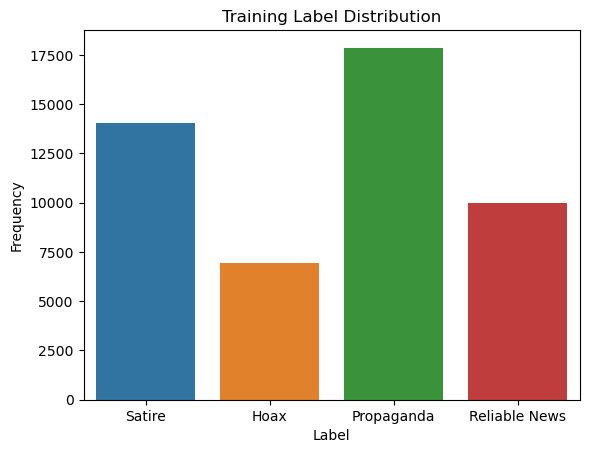

Propaganda       17870
Satire           14047
Reliable News     9995
Hoax              6942
Name: label, dtype: int64

In [16]:
sns.countplot(x='label', data=df_train)
plt.title('Training Label Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
df_train["label"].value_counts()

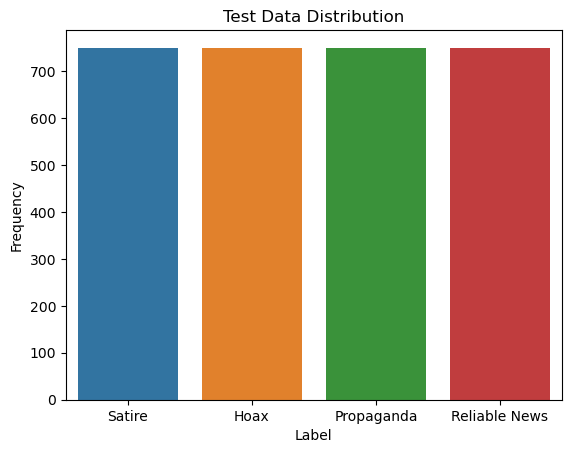

Satire           750
Hoax             750
Propaganda       750
Reliable News    750
Name: label, dtype: int64

In [17]:
sns.countplot(x='label', data=df_test)
plt.title('Test Data Distribution')
plt.xlabel('Label')
plt.ylabel('Frequency')
plt.show()
df_test["label"].value_counts()

# Basic Text Preprocessing

## Expand Contractions

In [18]:
def expand_contractions(corpus):
    return contractions.fix(corpus)

## Removal of Stop Words

In [19]:
def remove_stopwords(corpus):
    stop = nltk.corpus.stopwords.words('english')
    sentence = ""
    for word in corpus.split():
        if word not in stop:
            sentence += word
            sentence += " "
    return sentence.strip()

## Lemmitization with WordNetLemmitizer

In [20]:
def lemmatize_word(corpus):
    lemma = WordNetLemmatizer()
    sentence = ""
    for word in corpus.split():
        sentence += lemma.lemmatize(word)
        sentence += " "
    return sentence.strip()

## Preprocess the text

In [21]:
def preprocess_text(text):
    text_contractions_expanded = expand_contractions(text)
    text_no_stopwords = remove_stopwords(text_contractions_expanded)
    text_processed = lemmatize_word(text_no_stopwords)
    return text_processed

In [22]:
# Processing datasets
print("Processing dataset: df_train")
df_train['processed_text'] = df_train['text'].apply(preprocess_text)
print("Finished processing dataset: df_train")

print("Processing dataset: df_test")
df_test['processed_text'] = df_test['text'].apply(preprocess_text)
print("Finished processing dataset: df_test")

Processing dataset: df_train
Finished processing dataset: df_train
Processing dataset: df_test
Finished processing dataset: df_test


## Vectorizer- tfidf


In [23]:
def extract_ner_pos(text):
    doc = nlp(text)
    ner_tags = [ent.label_ for ent in doc.ents]  # Extract NER labels
    pos_tags = [token.pos_ for token in doc]      # Extract POS tags
    return ner_tags, pos_tags

# Add NER and POS features to the dataset
df_train[['ner_tags', 'pos_tags']] = df_train['processed_text'].apply(lambda text: pd.Series(extract_ner_pos(text)))

# Add sentiment scores and text lengths as additional features
sid = SentimentIntensityAnalyzer()
df_train['sentiment_score'] = df_train['processed_text'].apply(lambda text: sid.polarity_scores(text)['compound'])
df_train['text_length'] = df_train['processed_text'].apply(len)

# Concatenate NER and POS features with processed text for vectorization
df_train['ner_tags'] = df_train['ner_tags'].apply(lambda tags: ' '.join(tags))
df_train['pos_tags'] = df_train['pos_tags'].apply(lambda tags: ' '.join(tags))

In [24]:
df_train['sentiment_score'] = df_train['sentiment_score'].astype(str)
df_train['text_length'] = df_train['text_length'].astype(str)

# Concatenate features for vectorization
X_train_features = df_train['processed_text'] + ' ' + df_train['sentiment_score'] + ' ' + df_train['text_length']

In [10]:
# with pd.option_context('display.max_colwidth', None):  # Ensure full column width is displayed
#     for i in range(5):
#         print(X_train_features.iloc[i])

In [25]:
# Initialize TF-IDF vectorizer with desired parameters
tfidf_vectorizer = TfidfVectorizer(max_features=3000)

# Fit and transform the combined features using TF-IDF vectorizer
X_train_counts = tfidf_vectorizer.fit_transform(X_train_features)

# Perform PCA on the transformed data
pca = PCA(n_components=100)
X_train_pca = pca.fit_transform(X_train_counts.toarray())

# Perform oversampling using SMOTE
smote = SMOTE(random_state=42)
X_train_oversampled, y_train_oversampled = smote.fit_resample(X_train_pca, df_train['label'])

# # Add sentiment scores and text lengths to the oversampled dataset
# additional_features = df_train[['sentiment_score', 'text_length']].values
# X_train_oversampled = pd.concat([pd.DataFrame(X_train_oversampled), pd.DataFrame(additional_features)], axis=1)

# Split the dataset into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_oversampled, y_train_oversampled, test_size=0.2, random_state=42)


# simple neural network

In [26]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf

# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)

# Build a simple feedforward neural network
model = tf.keras.Sequential([
    tf.keras.layers.Dense(256, activation='relu', input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # Assuming 4 classes for classification
])

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the neural network
model.fit(X_train, y_train_encoded, epochs=30, batch_size=32, validation_split=0.2)


y_train_pred = np.argmax(model.predict(X_train), axis=1)
# y_test_pred = np.argmax(model.predict(X_test_processed), axis=1)

# Calculate accuracy for training and test datasets
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
print("Train Accuracy:", train_accuracy)


Epoch 1/30


/Users/sandhiyadhanasekaran/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1430/1430 ━━━━━━━━━━━━━━━━━━━━ 2s 962us/step - accuracy: 0.8732 - loss: 0.3681 - val_accuracy: 0.9502 - val_loss: 0.1423
Epoch 2/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 1s 911us/step - accuracy: 0.9564 - loss: 0.1258 - val_accuracy: 0.9585 - val_loss: 0.1168
Epoch 3/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 1s 907us/step - accuracy: 0.9658 - loss: 0.0978 - val_accuracy: 0.9642 - val_loss: 0.1056
Epoch 4/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 1s 914us/step - accuracy: 0.9710 - loss: 0.0824 - val_accuracy: 0.9632 - val_loss: 0.1105
Epoch 5/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 1s 934us/step - accuracy: 0.9768 - loss: 0.0662 - val_accuracy: 0.9674 - val_loss: 0.1023
Epoch 6/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 1s 991us/step - accuracy: 0.9816 - loss: 0.0562 - val_accuracy: 0.9646 - val_loss: 0.1108
Epoch 7/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 1s 928us/step - accuracy: 0.9846 - loss: 0.0467 - val_accuracy: 0.9685 - val_loss: 0.1013
Epoch 8/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 1s 930us/step - accuracy: 0.9861 - loss: 0.04

In [27]:
# # snn Evaluate the model

df_test[['ner_tags', 'pos_tags']] = df_test['processed_text'].apply(lambda text: pd.Series(extract_ner_pos(text)))

# Add sentiment scores and text lengths as additional features for the test dataset
test_sentiment_scores = df_test['processed_text'].apply(lambda text: sid.polarity_scores(text)['compound'])
test_text_lengths = df_test['processed_text'].apply(len)

test_additional_features = pd.DataFrame({'sentiment_score': test_sentiment_scores, 'text_length': test_text_lengths})

# Concatenate NER and POS features with processed text for vectorization
df_test['ner_tags'] = df_test['ner_tags'].apply(lambda tags: ' '.join(tags))
df_test['pos_tags'] = df_test['pos_tags'].apply(lambda tags: ' '.join(tags))
df_test['sentiment_score'] = test_additional_features['sentiment_score'].astype(str)
df_test['text_length'] = test_additional_features['text_length'].astype(str)

# Concatenate features for vectorization in the test dataset
X_test_features = df_test['processed_text'] + ' ' + df_test['sentiment_score'] + ' ' + df_test['text_length']



In [28]:
# Vectorize the text in the test dataset using the same vectorizer as used for training
X_test_vectorized = tfidf_vectorizer.transform(X_test_features)
X_test_pca = pca.transform(X_test_vectorized.toarray())

# Predict labels for the test dataset
y_test_pred =np.argmax(model.predict(X_test_pca),axis=1)

# Encode the actual labels in the test dataset
y_test_encoded = label_encoder.transform(df_test['label'])

# Calculate accuracy for the test dataset
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

print("Test Accuracy:", test_accuracy)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 945us/step
Test Accuracy: 0.726


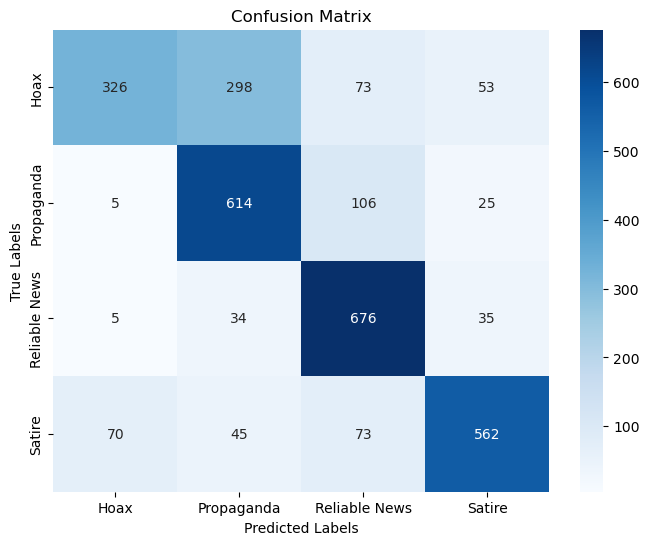

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [30]:
from sklearn.metrics import classification_report

# Calculate the classification report
report = classification_report(y_test_encoded, y_test_pred, target_names=label_encoder.classes_)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
               precision    recall  f1-score   support

         Hoax       0.80      0.43      0.56       750
   Propaganda       0.62      0.82      0.71       750
Reliable News       0.73      0.90      0.81       750
       Satire       0.83      0.75      0.79       750

     accuracy                           0.73      3000
    macro avg       0.75      0.73      0.72      3000
 weighted avg       0.75      0.73      0.72      3000



# Cnn

In [32]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

maxlen = 100  # Maximum sequence length
X_train_padded = pad_sequences(X_train, maxlen=maxlen, padding='post')


# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)


# Reshape data for 1D CNN input
X_train_padded = X_train_padded.reshape(X_train_padded.shape[0], X_train_padded.shape[1], 1)



# Build a simple feedforward neural network
model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(128, 5, activation='relu', input_shape=(maxlen, 1)),
    tf.keras.layers.MaxPooling1D(2),
    tf.keras.layers.Conv1D(64, 5, activation='relu'),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(4, activation='softmax')  # Assuming 4 classes for classification
])


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the neural network
model.fit(X_train, y_train_encoded, epochs=30, batch_size=32, validation_split=0.2)


y_train_pred = np.argmax(model.predict(X_train), axis=1)
# y_test_pred = np.argmax(model.predict(X_test_processed), axis=1)

# Calculate accuracy for training and test datasets
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
print("Train Accuracy:", train_accuracy)


Epoch 1/30


/Users/sandhiyadhanasekaran/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1430/1430 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.4182 - loss: 1.2353 - val_accuracy: 0.6017 - val_loss: 0.9780
Epoch 2/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.6275 - loss: 0.8975 - val_accuracy: 0.6957 - val_loss: 0.7577
Epoch 3/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7056 - loss: 0.7368 - val_accuracy: 0.7394 - val_loss: 0.6628
Epoch 4/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7474 - loss: 0.6545 - val_accuracy: 0.7665 - val_loss: 0.6062
Epoch 5/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 13s 9ms/step - accuracy: 0.7682 - loss: 0.6036 - val_accuracy: 0.7700 - val_loss: 0.5778
Epoch 6/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.7842 - loss: 0.5608 - val_accuracy: 0.7965 - val_loss: 0.5399
Epoch 7/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step - accuracy: 0.7954 - loss: 0.5334 - val_accuracy: 0.8007 - val_loss: 0.5047
Epoch 8/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 11s 8ms/step - accuracy: 0.8070 - loss: 0.5084 - val

In [33]:
# # cnnEvaluate the model

df_test[['ner_tags', 'pos_tags']] = df_test['processed_text'].apply(lambda text: pd.Series(extract_ner_pos(text)))

# Add sentiment scores and text lengths as additional features for the test dataset
test_sentiment_scores = df_test['processed_text'].apply(lambda text: sid.polarity_scores(text)['compound'])
test_text_lengths = df_test['processed_text'].apply(len)

test_additional_features = pd.DataFrame({'sentiment_score': test_sentiment_scores, 'text_length': test_text_lengths})

# Concatenate NER and POS features with processed text for vectorization
df_test['ner_tags'] = df_test['ner_tags'].apply(lambda tags: ' '.join(tags))
df_test['pos_tags'] = df_test['pos_tags'].apply(lambda tags: ' '.join(tags))
df_test['sentiment_score'] = test_additional_features['sentiment_score'].astype(str)
df_test['text_length'] = test_additional_features['text_length'].astype(str)

# Concatenate features for vectorization in the test dataset
X_test_features = df_test['processed_text'] + ' ' + df_test['sentiment_score'] + ' ' + df_test['text_length']

# Vectorize the text in the test dataset using the same vectorizer as used for training
X_test_vectorized = tfidf_vectorizer.transform(X_test_features)
X_test_pca = pca.transform(X_test_vectorized.toarray())

# Predict labels for the test dataset
y_test_pred =np.argmax(model.predict(X_test_pca),axis=1)

# Encode the actual labels in the test dataset
y_test_encoded = label_encoder.transform(df_test['label'])

# Calculate accuracy for the test dataset
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

print("Test Accuracy:", test_accuracy)

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Test Accuracy: 0.6763333333333333


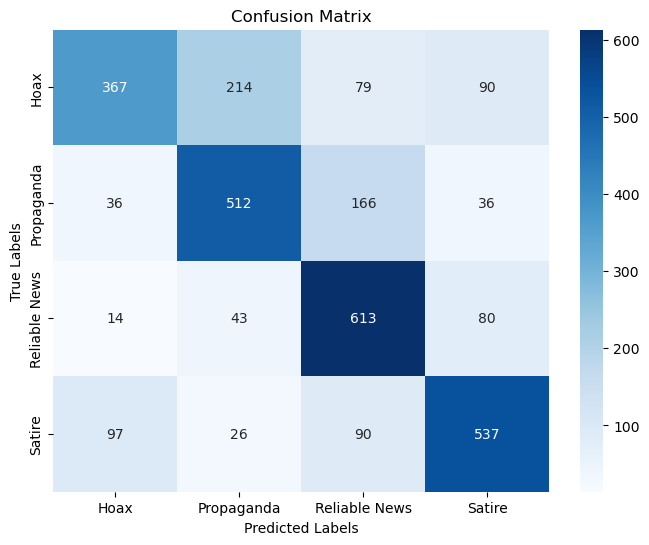

In [34]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# CNN-LSTM

In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense

maxlen = 100  # Maximum sequence length
X_train_padded = pad_sequences(X_train, maxlen=maxlen, padding='post')


# Encode the target variable
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)


# Reshape data for 1D CNN input
X_train_padded = X_train_padded.reshape(X_train_padded.shape[0], X_train_padded.shape[1], 1)


model = Sequential()
model.add(Conv1D(128, 5, activation='relu', input_shape=(maxlen, 1)))
model.add(MaxPooling1D(2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(2))
model.add(LSTM(64))  # LSTM layer after CNN layers
model.add(Dense(64, activation='relu'))
model.add(Dense(4, activation='softmax'))  # Assuming 4 classes for classification


# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the neural network
model.fit(X_train, y_train_encoded, epochs=30, batch_size=32, validation_split=0.2)


y_train_pred = np.argmax(model.predict(X_train), axis=1)
# y_test_pred = np.argmax(model.predict(X_test_processed), axis=1)

# Calculate accuracy for training and test datasets
train_accuracy = accuracy_score(y_train_encoded, y_train_pred)
print("Train Accuracy:", train_accuracy)


Epoch 1/30


/Users/sandhiyadhanasekaran/anaconda3/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


1430/1430 ━━━━━━━━━━━━━━━━━━━━ 21s 13ms/step - accuracy: 0.4930 - loss: 1.0503 - val_accuracy: 0.8335 - val_loss: 0.4472
Epoch 2/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8386 - loss: 0.4372 - val_accuracy: 0.8492 - val_loss: 0.4137
Epoch 3/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.8686 - loss: 0.3580 - val_accuracy: 0.8832 - val_loss: 0.3238
Epoch 4/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - accuracy: 0.8850 - loss: 0.3202 - val_accuracy: 0.8894 - val_loss: 0.2906
Epoch 5/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.8916 - loss: 0.2976 - val_accuracy: 0.8976 - val_loss: 0.2849
Epoch 6/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.8965 - loss: 0.2905 - val_accuracy: 0.9042 - val_loss: 0.2628
Epoch 7/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 18s 13ms/step - accuracy: 0.9009 - loss: 0.2756 - val_accuracy: 0.8997 - val_loss: 0.2925
Epoch 8/30
1430/1430 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.9078 - loss: 0.25

In [36]:
# # # cnnEvaluate the model

df_test[['ner_tags', 'pos_tags']] = df_test['processed_text'].apply(lambda text: pd.Series(extract_ner_pos(text)))

# Add sentiment scores and text lengths as additional features for the test dataset
test_sentiment_scores = df_test['processed_text'].apply(lambda text: sid.polarity_scores(text)['compound'])
test_text_lengths = df_test['processed_text'].apply(len)

test_additional_features = pd.DataFrame({'sentiment_score': test_sentiment_scores, 'text_length': test_text_lengths})

# Concatenate NER and POS features with processed text for vectorization
df_test['ner_tags'] = df_test['ner_tags'].apply(lambda tags: ' '.join(tags))
df_test['pos_tags'] = df_test['pos_tags'].apply(lambda tags: ' '.join(tags))
df_test['sentiment_score'] = test_additional_features['sentiment_score'].astype(str)
df_test['text_length'] = test_additional_features['text_length'].astype(str)

# Concatenate features for vectorization in the test dataset
X_test_features = df_test['processed_text'] + ' ' + df_test['sentiment_score'] + ' ' + df_test['text_length']

# Vectorize the text in the test dataset using the same vectorizer as used for training
X_test_vectorized = tfidf_vectorizer.transform(X_test_features)
X_test_pca = pca.transform(X_test_vectorized.toarray())

# Predict labels for the test dataset
y_test_pred =np.argmax(model.predict(X_test_pca),axis=1)

# Encode the actual labels in the test dataset
y_test_encoded = label_encoder.transform(df_test['label'])

# Calculate accuracy for the test dataset
test_accuracy = accuracy_score(y_test_encoded, y_test_pred)

print("Test Accuracy:", test_accuracy)

94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Test Accuracy: 0.709


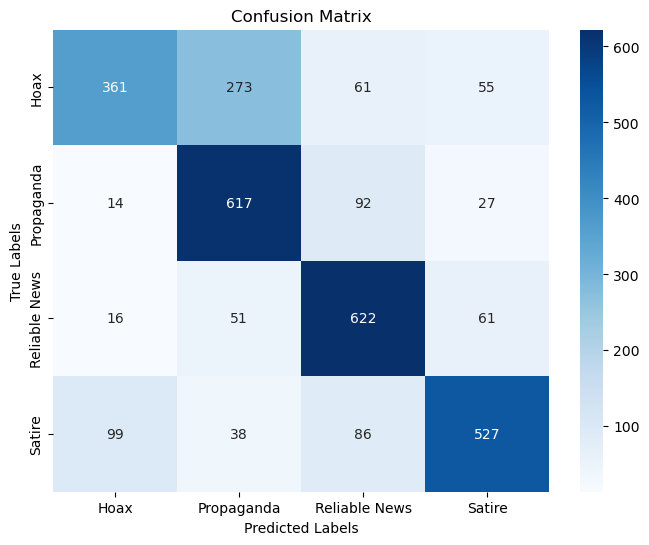

In [37]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_test_pred)

# Plot the confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()